In [68]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import function
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Multiply
from tensorflow.keras.applications import InceptionV3,MobileNet

In [69]:
# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Local and Global Attention Module Declaration

In [70]:
# 3. Create the ensemble attention-augmented MobileNet model
def attention_module1(input_tensor, kernel_size=3):
    # Local attention module implementation
    x = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(input_tensor)
    x = Multiply()([input_tensor, x])

    # Apply local attention by convolving with a kernel centered on each pixel
    local_attention = Conv2D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid')(x)
    x = Multiply()([x, local_attention])
    
    return x

def attention_module2(input_tensor):
    # Apply global attention by computing global average pooling
    attention_weights = GlobalAveragePooling2D()(input_tensor)
    attention_weights = Dense(1, activation='sigmoid')(attention_weights)
    attention_weights = Multiply()([input_tensor, attention_weights])
    return attention_weights



In [71]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda,Concatenate,BatchNormalization
from keras import backend as K
from keras.activations import sigmoid

def attach_attention_module(net, attention_module):
  if attention_module == 'se_block': # SE_block
    net = se_block(net)
  elif attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

def se_block(input_feature, ratio=8):
	"""Contains the implementation of Squeeze-and-Excitation(SE) block.
	As described in https://arxiv.org/abs/1709.01507.
	"""
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	se_feature = GlobalAveragePooling2D()(input_feature)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	se_feature = Dense(channel // ratio,
					   activation='relu',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel//ratio)
	se_feature = Dense(channel,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	if K.image_data_format() == 'channels_first':
		se_feature = Permute((3, 1, 2))(se_feature)

	se_feature = multiply([input_feature, se_feature])
	return se_feature

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
    
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])
		

# Local+Global Mobile Net Model Fine Tuning

In [72]:
def create_ensemble_attention_augmented_mobilenet(input_shape, num_classes,attention=True):
    # Load MobileNet base model without top layer
    base_model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    # Attention augmented MobileNet architecture
    input_tensor = Input(shape=input_shape)
    x = base_model(input_tensor)

    # Apply attention modules
    if(attention):
        x = Add()([attach_attention_module(x, attention_module='cbam_block'),x])
        x = BatchNormalization()(x)
        x = Activation('relu')(x)  # Applying ReLU activation after batch normalization
    #global_attention = attention_module2(x)
    #local_attention = attention_module1(global_attention)

    # Concatenate the outputs of both attention modules
    #concatenated_attention = AveragePooling2D()(tf.keras.layers.Concatenate()([local_attention, global_attention]))

    # Add classification layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

In [73]:
import numpy as np
from sklearn.metrics import classification_report, balanced_accuracy_score, average_precision_score, confusion_matrix

def evaluate_classification(y_true, y_pred, average='macro'):
    """
    Evaluate the classification performance and calculate micro-average, balanced accuracy, and average precision.

    Parameters:
        y_true (numpy array or list): True labels.
        y_pred (numpy array or list): Predicted labels.
        average (str, optional): The averaging strategy to use for average precision.
                                 Possible values are 'macro', 'micro', 'weighted', and None.
                                 Default is 'macro'.

    Returns:
        report (str): The classification report as a string.
        balanced_acc (float): The balanced accuracy.
        avg_precision (float): The average precision.
        micro_avg_precision (float): The micro-average precision.
        micro_avg_recall (float): The micro-average recall.
        micro_avg_f1_score (float): The micro-average F1-score.
    """
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    avg_precision = average_precision_score(y_true, y_pred, average=average)

    # Calculate micro-average precision and recall using confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tp_sum = np.sum(np.diag(cm))
    pred_sum = np.sum(cm, axis=0)
    true_sum = np.sum(cm, axis=1)
    micro_avg_precision = tp_sum / pred_sum.sum()
    micro_avg_recall = tp_sum / true_sum.sum()
    micro_avg_f1_score = 2 * (micro_avg_precision * micro_avg_recall) / (micro_avg_precision + micro_avg_recall)

    return report, balanced_acc, avg_precision, micro_avg_precision, micro_avg_recall, micro_avg_f1_score


# Local + Global InceptionV3 Model Fine Tuning

In [74]:
def create_ensemble_attention_augmented_inceptionv3(input_shape, num_classes,attention=True):
    # Load InceptionV3 base model without top layer
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    # Attention augmented InceptionV3 architecture
    input_tensor = Input(shape=input_shape)
    x = base_model(input_tensor)
    if(attention):
        x = Add()([attach_attention_module(x, attention_module='cbam_block'),x])
        x = BatchNormalization()(x)
        x = Activation('relu')(x)  # Applying ReLU activation after batch normalization
    # Apply attention modules
    #global_attention = attention_module2(x)
    #local_attention = attention_module1(global_attention)

    # Concatenate the outputs of both attention modules
    #concatenated_attention = AveragePooling2D()(tf.keras.layers.Concatenate()([local_attention, global_attention]))

    # Add classification layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

# Local+Global DenseNet121

# constant Declaration

In [75]:
# 1. Load and split the dataset
train_data_dir = '/kaggle/input/cataract-image-dataset/processed_images/train'
#validation_data_dir = 'd:/chaman/cataract/test'
input_shape = (224, 224)
batch_size = 32
num_classes=2


# Traing and Validation + Data Augmentation Module

In [76]:
# 2. Preprocess the images
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation split
)

#validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',  # Updated to 'categorical'
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Subset for validation data
)

Found 393 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


# Local+Global MobileNet Model Compilation

In [77]:

MobileNetModel = create_ensemble_attention_augmented_mobilenet(input_shape + (3,), num_classes)

# 4. Compile the model
MobileNetModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Local + Global InceptionV3 Model Compilation

In [78]:
InceptionV3Model = create_ensemble_attention_augmented_inceptionv3(input_shape + (3,), num_classes)

InceptionV3Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [94]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation loss
    patience=40,          # Number of epochs with no improvement to wait
    restore_best_weights=True,  # Restore the best model weights when stopping

)
cp_callback1 = tf.keras.callbacks.ModelCheckpoint('./fpseweights.h5', save_weights_only=True, verbose=1, save_best_only=True)

In [95]:
cp_callback2 = tf.keras.callbacks.ModelCheckpoint('./fpseweights1.h5', save_weights_only=True, verbose=1, save_best_only=True)
cp_callback3 = tf.keras.callbacks.ModelCheckpoint('./fpseweights2.h5', save_weights_only=True, verbose=1, save_best_only=True)

# Local+Global MobileNet Model Training

In [96]:
# 5. Train the model
epochs = 20

# Create a directory to save the best model weights during training
os.makedirs('models', exist_ok=True)
model_checkpoint = ModelCheckpoint('models/best_model1.h5', save_best_only=True, save_weights_only=True)

history = MobileNetModel.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[model_checkpoint,cp_callback1]
)


Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9861
Epoch 1: val_loss improved from inf to 0.04984, saving model to ./fpseweights.h5
12/12 [==============================] - 18s 2s/step - loss: 0.0433 - accuracy: 0.9861 - val_loss: 0.0498 - val_accuracy: 0.9792
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9889
Epoch 2: val_loss improved from 0.04984 to 0.04831, saving model to ./fpseweights.h5
12/12 [==============================] - 20s 2s/step - loss: 0.0325 - accuracy: 0.9889 - val_loss: 0.0483 - val_accuracy: 0.9688
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9945
Epoch 3: val_loss improved from 0.04831 to 0.03085, saving model to ./fpseweights.h5
12/12 [==============================] - 20s 2s/step - loss: 0.0329 - accuracy: 0.9945 - val_loss: 0.0308 - val_accuracy: 0.9896
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 0.0277 - acc

# Local + Global InceptionV3 Model Training

In [97]:
# Create a directory to save the best model weights during training
os.makedirs('models', exist_ok=True)
model_checkpoint = ModelCheckpoint('models/best_InceptionModel1.h5', save_best_only=True, save_weights_only=True)

InceptionV3history = InceptionV3Model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[model_checkpoint,cp_callback2]
)


Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9529
Epoch 1: val_loss improved from inf to 0.08434, saving model to ./fpseweights1.h5
12/12 [==============================] - 19s 2s/step - loss: 0.0946 - accuracy: 0.9529 - val_loss: 0.0843 - val_accuracy: 0.9688
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.9418
Epoch 2: val_loss did not improve from 0.08434
12/12 [==============================] - 18s 2s/step - loss: 0.1766 - accuracy: 0.9418 - val_loss: 0.1849 - val_accuracy: 0.9479
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9474
Epoch 3: val_loss did not improve from 0.08434
12/12 [==============================] - 19s 2s/step - loss: 0.1312 - accuracy: 0.9474 - val_loss: 0.1052 - val_accuracy: 0.9688
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9501
Epoch 4: val_loss improved from 0.08434 to 0.08432, saving mo

In [98]:
MobileNetModel.save('GLAAMD1.h5')
InceptionV3Model.save('GLAAIV3D1.h5')

# Local+Global MobileNet Model Validation Evaluation

In [99]:
# 6. Evaluate the model
MobileNetEvaluation = MobileNetModel.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(MobileNetEvaluation[1] * 100))

4/4 [==============================] - 2s 525ms/step - loss: 0.0883 - accuracy: 0.9694
Validation Accuracy: 96.94%


# Local+Global InceptionV3 Model Validation Evaluation

In [100]:
# 6. Evaluate the model
InceptionV3Evaluation = InceptionV3Model.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(InceptionV3Evaluation[1] * 100))

4/4 [==============================] - 2s 543ms/step - loss: 0.0595 - accuracy: 0.9898
Validation Accuracy: 98.98%


# Common TestGenerator Declaration Module

In [101]:
# Test data directory
test_data_dir = '/kaggle/input/cataract-image-dataset/processed_images/test'
input_shape = (224, 224)
batch_size = 32

# Preprocess the test images
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',  # Set to 'categorical' if you used the updated code
    shuffle=False
)

# Load the saved model



Found 121 images belonging to 2 classes.


# # Local+Global MobileNet Model Test Evaluation

In [102]:
# Evaluate the model on the test set
MobileNetTestEvaluation = MobileNetModel.evaluate_generator(test_generator)
print("Test Accuracy: {:.2f}%".format(MobileNetTestEvaluation[1] * 100))

/tmp/ipykernel_28/4230226302.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  MobileNetTestEvaluation = MobileNetModel.evaluate_generator(test_generator)


Test Accuracy: 94.21%


# Local+Global InceptionV3 Model Test Evaluation

In [103]:
# Evaluate the model on the test set
InceptionV3TestEvaluation = InceptionV3Model.evaluate_generator(test_generator)
print("Test Accuracy: {:.2f}%".format(InceptionV3TestEvaluation[1] * 100))

/tmp/ipykernel_28/1916027015.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  InceptionV3TestEvaluation = InceptionV3Model.evaluate_generator(test_generator)


Test Accuracy: 92.56%


# Common Classification Report Module

In [104]:
from sklearn.metrics import classification_report

# Load the saved model
#model = tf.keras.models.load_model('models/final_model.h5')  # Update with the correct path

# Get the true labels for the test set
true_labels = test_generator.classes

# Compute and print the classification report
class_names = list(test_generator.class_indices.keys())


# Local+Global MobileNet Model Classification Report

In [105]:
# Generate predictions for the test set
MobileNetPredictions = MobileNetModel.predict_generator(test_generator)
MobileNetPredicted_labels = np.argmax(MobileNetPredictions, axis=1)
MobileNetReport = classification_report(true_labels, MobileNetPredicted_labels, target_names=class_names)
print(MobileNetReport)


/tmp/ipykernel_28/2479908967.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  MobileNetPredictions = MobileNetModel.predict_generator(test_generator)


              precision    recall  f1-score   support

    cataract       0.92      0.97      0.94        61
      normal       0.96      0.92      0.94        60

    accuracy                           0.94       121
   macro avg       0.94      0.94      0.94       121
weighted avg       0.94      0.94      0.94       121



In [106]:
report, balanced_acc, avg_precision, micro_avg_precision, micro_avg_recall, micro_avg_f1_score = evaluate_classification(true_labels,  MobileNetPredicted_labels)

# Print the classification report and additional metrics
#print("Classification Report:\n", report)
print("Micro-average F1-score:", micro_avg_f1_score)
print("Balanced Accuracy:", balanced_acc)
print("Average Precision:", avg_precision)
print("Micro-average Precision:", micro_avg_precision)
print("Micro-average Recall:", micro_avg_recall)

Micro-average F1-score: 0.9421487603305785
Balanced Accuracy: 0.9419398907103824
Average Precision: 0.9258252380261949
Micro-average Precision: 0.9421487603305785
Micro-average Recall: 0.9421487603305785


# Local+Global InceptionV3 Model Classification Report

In [107]:
# Generate predictions for the test set
InceptionV3Predictions = InceptionV3Model.predict_generator(test_generator)
InceptionV3Predicted_labels = np.argmax(InceptionV3Predictions, axis=1)
InceptionV3Report = classification_report(true_labels, InceptionV3Predicted_labels, target_names=class_names)
print(InceptionV3Report)


/tmp/ipykernel_28/1935537709.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  InceptionV3Predictions = InceptionV3Model.predict_generator(test_generator)


              precision    recall  f1-score   support

    cataract       0.91      0.95      0.93        61
      normal       0.95      0.90      0.92        60

    accuracy                           0.93       121
   macro avg       0.93      0.93      0.93       121
weighted avg       0.93      0.93      0.93       121



In [108]:
report, balanced_acc, avg_precision, micro_avg_precision, micro_avg_recall, micro_avg_f1_score = evaluate_classification(true_labels,  InceptionV3Predicted_labels)

# Print the classification report and additional metrics
#print("Classification Report:\n", report)
print("Micro-average F1-score:", micro_avg_f1_score)
print("Balanced Accuracy:", balanced_acc)
print("Average Precision:", avg_precision)
print("Micro-average Precision:", micro_avg_precision)
print("Micro-average Recall:", micro_avg_recall)

Micro-average F1-score: 0.9256198347107438
Balanced Accuracy: 0.9254098360655738
Average Precision: 0.9022183558068725
Micro-average Precision: 0.9256198347107438
Micro-average Recall: 0.9256198347107438


# Local+Global MobileNet Model Confusion Matrix

<Figure size 500x400 with 0 Axes>

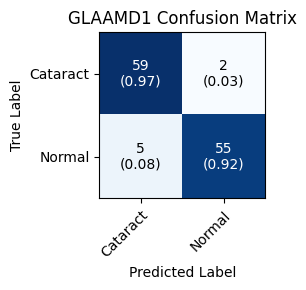

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix


# Load the saved model
#model = tf.keras.models.load_model('models/final_model.h5')  # Update with the correct path

# Generate predictions for the test data


# Generate the confusion matrix
MobileNetCM = confusion_matrix(true_labels, MobileNetPredicted_labels)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
class_names = list(test_generator.class_indices.keys())
#sns.heatmap(MobileNetCM, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plot_confusion_matrix(conf_mat=MobileNetCM, figsize=(5, 3), class_names=['Cataract', 'Normal'], show_normed=True)
plt.title('GLAAMD1 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('LGAAMD1.eps',dpi=250)
plt.show()


# Local+Global Inceptionv3 Model Confusion Matrix

<Figure size 500x300 with 0 Axes>

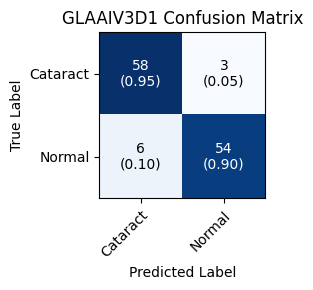

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the saved model
#model = tf.keras.models.load_model('models/final_model.h5')  # Update with the correct path

# Generate predictions for the test data


# Generate the confusion matrix
InceptionV3CM = confusion_matrix(true_labels, InceptionV3Predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
class_names = list(test_generator.class_indices.keys())
#sns.heatmap(InceptionV3CM, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plot_confusion_matrix(conf_mat=InceptionV3CM, figsize=(5, 3), class_names=['Cataract', 'Normal'], show_normed=True)
plt.title('GLAAIV3D1 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('LGAAID1.eps',dpi=250)
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_model1, tpr_model1, thresholds_model1 = roc_curve(true_labels, MobileNetPredicted_labels)
auc_model1 = roc_auc_score(true_labels, MobileNetPredicted_labels)

# Calculate ROC curve and AUC for Model 2
fpr_model2, tpr_model2, thresholds_model2 = roc_curve(true_labels, InceptionV3Predicted_labels)
auc_model2 = roc_auc_score(true_labels, InceptionV3Predicted_labels)


In [ ]:
import matplotlib.pyplot as plt

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, label='GLAAMD1 (AUC = {:.2f})'.format(auc_model1))
plt.plot(fpr_model2, tpr_model2, label='GLAAIV3D1 (AUC = {:.2f})'.format(auc_model2))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('CombinedROCCurveD1.eps',dpi=250)
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve

# Assuming you have predictions and true labels for both models
# Replace 'MobileNetPredicted_labels' and 'InceptionV3Predicted_labels' with the predictions of your models
# Replace 'true_labels' with the true labels of your data

# Calculate precision-recall curve for Model 1
precision_model1, recall_model1, thresholds_model1 = precision_recall_curve(true_labels, MobileNetPredicted_labels)

# Calculate precision-recall curve for Model 2
precision_model2, recall_model2, thresholds_model2 = precision_recall_curve(true_labels, InceptionV3Predicted_labels)

import matplotlib.pyplot as plt

# Plot the precision-recall curves for both models
plt.figure(figsize=(8, 6))
plt.plot(recall_model1, precision_model1, marker='.', label='GLAAMD1')
plt.plot(recall_model2, precision_model2, marker='.', label='GLAAIV3D1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()

# Annotate points with precision-recall values for Model 1
for p, r, t in zip(precision_model1, recall_model1, thresholds_model1):
    plt.annotate(f'GLAAMD1: {t:.2f}\n{p:.2f}/{r:.2f}', xy=(r, p), xytext=(r + 0.03, p), arrowprops=dict(arrowstyle='->'), fontsize=8)

# Annotate points with precision-recall values for Model 2
for p, r, t in zip(precision_model2, recall_model2, thresholds_model2):
    plt.annotate(f'GLAAIV3D1: {t:.2f}\n{p:.2f}/{r:.2f}', xy=(r, p), xytext=(r - 0.15, p), arrowprops=dict(arrowstyle='->'), fontsize=8)

plt.grid(True)
plt.savefig('combineprcurve.eps',dpi=250)
plt.show()


In [ ]:
MobileNetModel.summary()

In [ ]:
import numpy as np
import cv2
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Step 1: Load and preprocess the image data (Replace 'your_image_path' with the image you want to visualize)
# Step 1: Load and preprocess the image data
test_folder = 'd:/chaman/cataract/test'
input_size = (224, 224)  # Input size of the model, adjust according to your model's input size
# Step 2: Pick 4 sample images (2 from 'cataract' class and 2 from 'normal' class)
class_folders = ['cataract', 'normal']
sample_images = []

for class_folder in class_folders:
    class_path = os.path.join(test_folder, class_folder)
    images = os.listdir(class_path)
    sample_images.extend(random.sample(images, 2))

def preprocess_image(image_path, input_size):
    img = load_img(image_path, target_size=input_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)  # Preprocess based on VGG16 requirements
    return img


# Step 3: Define a function to compute the Grad-CAM visualization
def compute_gradcam(model, image):
    # Get the last convolutional layer and the output layer of the model
    last_conv_layer = model.get_layer('multiply_2')
    output_layer = model.layers[-1]

    # Create a model that maps the input image to the output class predictions and the last convolutional layer
    grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, output_layer.output])

    # Compute the gradients of the predicted class with respect to the last convolutional layer
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, 0]  # Assuming binary classification, change this if you have different output classes

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by its corresponding gradient importance
    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(tf.multiply(conv_output, pooled_grads), axis=-1)
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU activation
    heatmap /= np.max(heatmap)  # Normalize the heatmap values between 0 and 1

    return heatmap


# Create a figure with subplots for original images and their Grad-CAM images
num_images = len(sample_images)
fig, axes = plt.subplots(2, num_images, figsize=(4*num_images, 8))

# Generate Grad-CAM for each image and plot the results
for i, image_name in enumerate(sample_images):
    class_folder = 'cataract' if 'cataract' in image_name else 'normal'
    image_path = os.path.join(test_folder, class_folder, image_name)
    image = preprocess_image(image_path, input_size)
    heatmap = compute_gradcam(MobileNetModel, image)
    heatmap = cv2.resize(heatmap, (input_size[1], input_size[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Load the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.resize(original_image, (input_size[1], input_size[0]))

    # Overlay the heatmap on the original image
    alpha = 0.5  # Adjust the alpha value for the heatmap overlay
    superimposed_img = cv2.addWeighted(original_image, alpha, heatmap, 1 - alpha, 0)

    # Display the original image and Grad-CAM side by side
    axes[0, i].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0, i].set_title('Original Image')
    axes[0, i].axis('off')

    axes[1, i].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    axes[1, i].set_title('Grad-CAM Visualization')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('LGAAM_D1_GradCamVisualization.png',dpi=250)
plt.show()

In the Grad-CAM heatmap:

Regions with warm colors (e.g., red, orange, and yellow) indicate high importance or high activation. 
These regions are crucial for the model's prediction, and the model relies heavily on the features extracted 
from these areas to make its decision.

Regions with cool colors (e.g., blue and green) indicate low importance or low activation. 
These regions are less relevant to the model's prediction, and the model does not rely much on 
the features from these areas to make its decision.

In a binary classification scenario like this, where the model predicts between 'cataract' and 'normal' 
classes, the heatmap will show which parts of the image the model considers important for classifying 
the input as 'cataract' (warm regions) and which parts are not as relevant for the 'normal' class (cool regions).

# Stack Ensemble Local+Global Model

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNet, InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the dataset
dataset_dir = 'd:/chaman/cataract'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Image size for the models
image_size = (224, 224)
batch_size = 32
num_classes = 2
epochs = 20

# Implement the data loading and preparation functions
def prepare_data():
    datagen = ImageDataGenerator(rescale=1.0/255.0,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,
    shear_range=0.2,zoom_range=0.2,horizontal_flip=True, validation_split=0.2)
    train_generator = datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size,
                                                  class_mode='categorical', subset='training', shuffle=True)
    val_generator = datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size,
                                                class_mode='categorical', subset='validation', shuffle=False)

    return train_generator, val_generator

def train_model(model_fn, input_shape, num_classes, train_generator, val_generator):
    model = model_fn(input_shape, num_classes)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train_generator, epochs=epochs, validation_data=val_generator)
    return model

def bagging_ensemble(models, val_generator):
    # Make predictions for each model
    predictions = [model.predict(val_generator) for model in models]
    # Average the predictions of all models
    return np.mean(predictions, axis=0)

def stacking_ensemble(models, meta_model, val_generator):
    # Make predictions for each model
    predictions = [model.predict(val_generator) for model in models]
    stacked_predictions = np.hstack(predictions)

    # Use the stacked predictions to train the meta-model
    meta_model.fit(stacked_predictions, val_generator.classes, epochs=epochs)

    # Make predictions using the meta-model
    ensemble_predictions = [model.predict(val_generator) for model in models]
    stacked_ensemble_predictions = np.hstack(ensemble_predictions)
    meta_predictions = meta_model.predict(stacked_ensemble_predictions)

    return meta_predictions



In [ ]:
if __name__ == "__main__":
    # Prepare the data
    train_generator, val_generator = prepare_data()

    # Ensemble size (the number of models in the ensemble)
    ensemble_size = 5

    # Create and train ensemble models
    ensemble_models = []
    for i in range(ensemble_size):
        # Bootstrap sampling (with replacement) for training data
        train_generator_sample = train_generator
        model_fn = create_ensemble_attention_augmented_mobilenet if i % 2 == 0 else create_ensemble_attention_augmented_inceptionv3
        model = train_model(model_fn, image_size + (3,), num_classes, train_generator_sample, val_generator)
        ensemble_models.append(model)

    # Create the meta-model for stacking
    input_shape = (ensemble_size * num_classes,)
    meta_model = tf.keras.Sequential([
        Input(shape=input_shape),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    meta_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Make predictions using the stacking ensemble method
    stacking_predictions = stacking_ensemble(ensemble_models, meta_model, val_generator)

    # Threshold predictions for binary classification
    y_val = val_generator.classes
    stacking_predictions_binary = (stacking_predictions.argmax(axis=1) > 0.5).astype(int)

    # Evaluate the stacking ensemble performance
    stacking_accuracy = np.mean(stacking_predictions_binary == y_val)
    print(f"Stacking Ensemble Accuracy: {stacking_accuracy}")

In [ ]:
# Make predictions on the test data using the stacking ensemble method
test_stacking_predictions = stacking_ensemble(ensemble_models, meta_model, test_generator)

    # Threshold predictions for binary classification (if necessary)
test_stacking_predictions_binary = (test_stacking_predictions.argmax(axis=1) > 0.5).astype(int)

    # Evaluate the stacking ensemble performance on test data
y_test = test_generator.classes
test_stacking_accuracy = np.mean(test_stacking_predictions_binary == y_test)
print(f"Stacking Ensemble Accuracy on Test Data: {test_stacking_accuracy}")

In [ ]:
# Generate the classification report
class_names = test_generator.class_indices
class_names = [class_name for class_name, index in sorted(class_names.items(), key=lambda x: x[1])]
report = classification_report(y_test, test_stacking_predictions_binary, target_names=class_names)
print("Classification Report:")
print(report)

In [ ]:
report, balanced_acc, avg_precision, micro_avg_precision, micro_avg_recall, micro_avg_f1_score = evaluate_classification(true_labels,  test_stacking_predictions_binary)

# Print the classification report and additional metrics
#print("Classification Report:\n", report)
print("Micro-average F1-score:", micro_avg_f1_score)
print("Balanced Accuracy:", balanced_acc)
print("Average Precision:", avg_precision)
print("Micro-average Precision:", micro_avg_precision)
print("Micro-average Recall:", micro_avg_recall)

In [ ]:
# Generate the confusion matrix
confusion = confusion_matrix(y_test, test_stacking_predictions_binary)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
#sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plot_confusion_matrix(conf_mat=confusion, figsize=(5, 3), class_names=['Cataract', 'Normal'], show_normed=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SEnsemble Confusion Matrix')
#plt.savefig('SEnsembleCM.eps',dpi=250)
plt.show()

In [ ]:
# Calculate ROC curve and AUC for stacking ensemble
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)
fpr_stack, tpr_stack, thresholds_stack = roc_curve(y_test_one_hot[:, 1], test_stacking_predictions[:, 1])
roc_auc_stack = roc_auc_score(y_test_one_hot, test_stacking_predictions)

# Calculate ROC curve and AUC for Model 1 (LGMobileNetD1)
fpr_model1, tpr_model1, thresholds_model1 = roc_curve(true_labels, MobileNetPredicted_labels)
auc_model1 = roc_auc_score(true_labels, MobileNetPredicted_labels)

# Calculate ROC curve and AUC for Model 2 (LGInceptionV3D1)
fpr_model2, tpr_model2, thresholds_model2 = roc_curve(true_labels, InceptionV3Predicted_labels)
auc_model2 = roc_auc_score(true_labels, InceptionV3Predicted_labels)

# Plot ROC curves
plt.figure(figsize=(7, 5))
plt.plot(fpr_stack, tpr_stack, label='SEnsemble (AUC = {:.2f})'.format(roc_auc_stack), color='blue')
plt.plot(fpr_model1, tpr_model1, label='LGAAM_D1 (AUC = {:.2f})'.format(auc_model1), color='orange')
plt.plot(fpr_model2, tpr_model2, label='LGAAID1 (AUC = {:.2f})'.format(auc_model2), color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('SEnsemble_roc_curve_D1.eps',dpi=300)
plt.show()

In [ ]:
# Calculate precision-recall curve and thresholds for stacking ensemble
precision_stack, recall_stack, thresholds_pr_stack = precision_recall_curve(y_test_one_hot[:, 1], test_stacking_predictions[:, 1])

# Calculate precision-recall curve and thresholds for Model 1 (LGMobileNetD1)
precision_model1, recall_model1, thresholds_model1 = precision_recall_curve(true_labels, MobileNetPredicted_labels)

# Calculate precision-recall curve and thresholds for Model 2 (LGInceptionV3D1)
precision_model2, recall_model2, thresholds_model2 = precision_recall_curve(true_labels, InceptionV3Predicted_labels)

# Plot precision-recall curves
plt.figure(figsize=(7, 5))
plt.plot(recall_stack, precision_stack, marker='.', label='SEnsemble')
plt.plot(recall_model1, precision_model1, marker='.', label='LGAAMD1')
plt.plot(recall_model2, precision_model2, marker='.', label='LGAAID1')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.savefig('SEnsemble_PR_curve_D1.eps',dpi=300)
plt.show()